# 1 - Game Traffic Generator - VALORANT

This notebook provides a step-by-step solution to generate simplified gaming network traffic, based on captured packets.

## 1 - Capturing Packets

This step is done on wireshark, as described on the report. The capture is then saved as a PCAP file in this directory.

Here we will analyze data from the game VALORANT from RIOT GAMES STUDIO.

---
## 2 - Analyzing Packets

### 2.1 Getting the data

Access the captured packets generated by wireshark, and create a pandas dataframe with information about their inter-departure-time (IDT) and size.

Importing all the libraries used on the project

In [1]:
#
# Imports
#
import time
import dpkt
import random
import socket
import datetime
import threading  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import deque

Define some option related to how data is displayed on this notebook

In [2]:
#
# Global Jupyter Configurations
#

# set matplotlib's backend to inline, to properly render figures in jupyter
%matplotlib inline

# set maximum amount of display rows
pd.set_option('display.max_rows', 500)

Define a function to process the capture file into a pandas dataframe

In [3]:
def get_pcap_info(pcap):
    """Generates a pd.DataFrame with the packets, their IDT and size"""
    
    # sets auxiliar time for generating IDT
    previous_time = 0
    
    # list of packets with their info
    rows = []
    
    # iterate through every packet
    for (ts, buf) in pcap:
        
        # if it's the first packet, we don't have it's IDT
        if(previous_time == 0):
            previous_time = ts
            continue
            
        # get the packet
        packet = (ts, buf)
        
        # get the idt
        idt = int((ts-previous_time)*1000)
        
        # get the size
        size = len(buf)

        # create a new row with the packet information
        rows.append([packet, idt, size])
        
        # update previous_time
        previous_time = ts
    
    # return created dataframe
    return pd.DataFrame(rows, columns=["PACKET", "IDT", "SIZE"])

Let's get the data from the capture into the dataframe, and display its raw format

In [4]:
# open a packet capture file for reading
f = open('./Valorant_TDM_client_UDP.pcap', 'rb')
pcap = dpkt.pcap.Reader(f)

# generate a dataframe with the packet information
info = get_pcap_info(pcap)
info

,PACKET,IDT,SIZE
0,"(1600869281.405925, b'\x08j\n\x06\x97\x06\xb4....",29,91
1,"(1600869281.439408, b'\x08j\n\x06\x97\x06\xb4....",33,86
2,"(1600869281.473451, b'\x08j\n\x06\x97\x06\xb4....",34,277
3,"(1600869281.505844, b'\x08j\n\x06\x97\x06\xb4....",32,81
4,"(1600869283.011967, b'\x08j\n\x06\x97\x06\xb4....",1506,77
...,...,...,...
30674,"(1600869604.401711, b'\x08j\n\x06\x97\x06\xb4....",203,69
30675,"(1600869604.605059, b'\x08j\n\x06\x97\x06\xb4....",203,69
30676,"(1600869604.808899, b'\x08j\n\x06\x97\x06\xb4....",203,69
30677,"(1600869605.017171, b'\x08j\n\x06\x97\x06\xb4....",208,69


### 2.2 Checking for possible IDT, SIZE correlation

Visually check for any linear correlation between IDT and SIZE.

Text(0, 0.5, 'IDT')

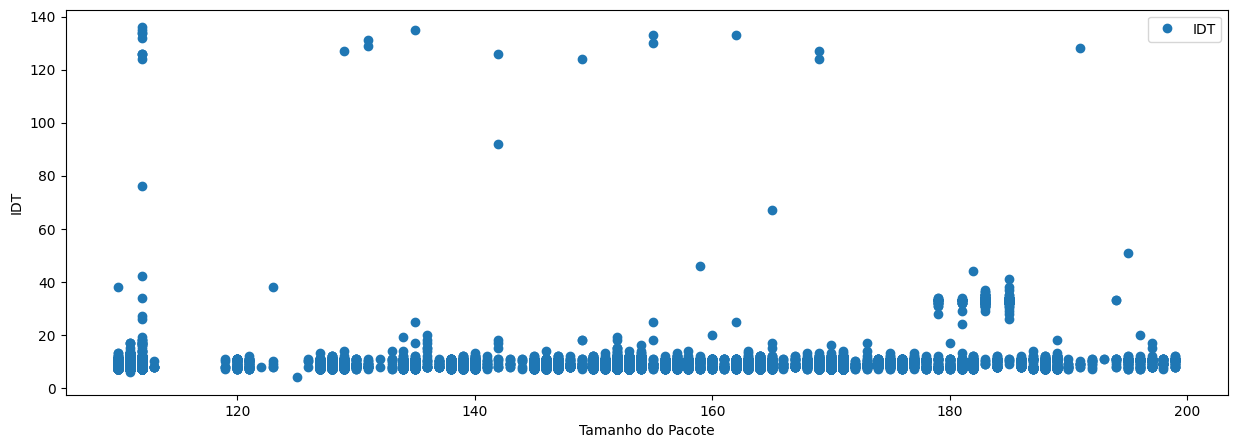

In [5]:
# filter out outliers that have no statistical representation, to get a better view of the relevant portion of data
correlation = info[(info['SIZE'] > 100) & (info['SIZE'] < 200)]

# plot the correlation between the two columns
ax = correlation.plot(x='SIZE', y='IDT', style='o', figsize=(15,5))
ax.set_xlabel("Tamanho do Pacote")
ax.set_ylabel("IDT")

Based on the graph, we can viasually see that IDT and SIZE are not correlated.

### 2.3 Analysing the data based on size

Create a probability distributed function (PDF), so we can see the frequency of each packet size.

In [6]:
# group our data in relation to size
pdf = info.groupby("SIZE").count()

# drop unnused column
pdf.drop(['IDT'],inplace=True, axis=1)

# rename column
pdf.columns = ['Count']

# convert each column to a percentage by dividing its grouped count value, by the total amount of data points
pdf["%"] = 100 * pdf["Count"] / len(info)

Let's create a copy to be compared with the final result later on

In [7]:
original_size_pdf = deepcopy(pdf)

Let's plot the produced PDF

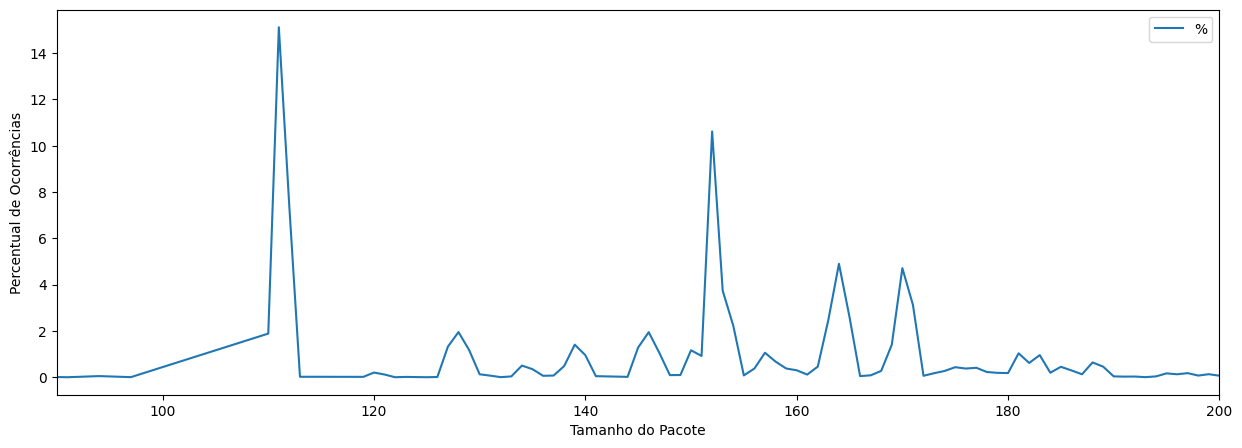

In [8]:
plt.figure(figsize=(15,5))

ax = pdf['%'].plot(label='%')
ax.legend(loc=1)
ax.set_xlim(90, 200) # here, we remove the outliers again
ax.set_xlabel("Tamanho do Pacote")
ax.set_ylabel("Percentual de Ocorrências")

plt.show()

Apply a wightened moving average to extract the most impactfull dataset points.

In [9]:
# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

These dummy rows are needed, because the moving average requires 10 points of data, around a central point.
If we were to just run the moving average without dummy rows, we would never be centered to some very relevant points of data at the begining of the dataset.

In [10]:
# define the weights
weights = np.array([1,2,3,4,5,6,5,4,3,2,1])

# aply the weighted moving average
WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)

# convert series to dataframe
WMA = WMA_raw.to_frame()

Let's plot PDF in comparison with WMA

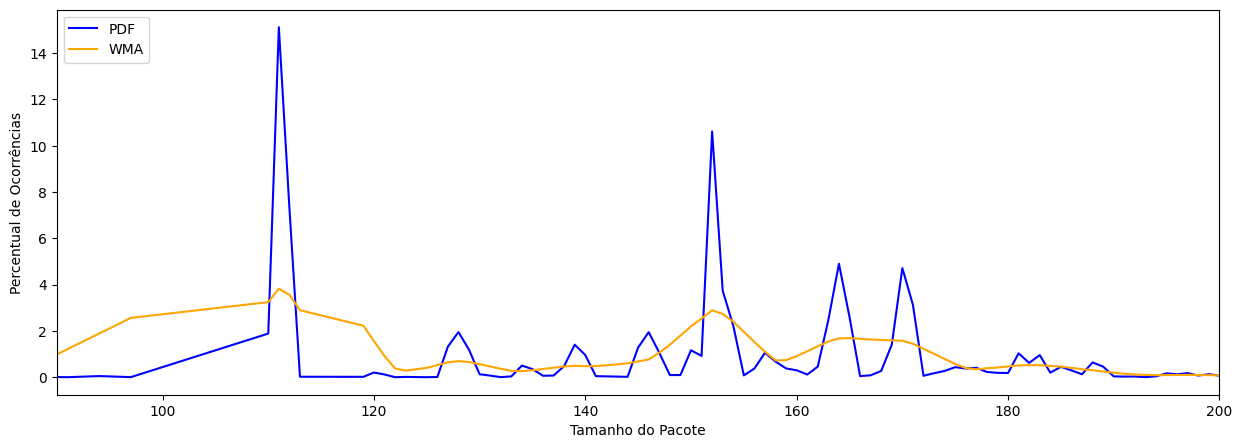

In [11]:
plt.figure(figsize=(15,5))

ax1 = pdf['%'].plot(color='blue', label='PDF')
ax2 = WMA_raw.plot.line(color='orange',  label='WMA')

ax1.legend(loc=1)
ax2.legend(loc=2)

ax1.set_xlim(90, 200)
ax2.set_xlim(90, 200)

ax1.set_xlabel("Tamanho do Pacote")
ax1.set_ylabel("Percentual de Ocorrências")

plt.show()

To populate the major dataset, we can append the PDF bigger than WMA, and do as many iteractions as we wish, depending on how simplified we want the major dataset to be.
This essentially works as a filter, to grab more relevant points of data in a determined zone of a size group.

In [12]:
# define the number of iterations we are doing of the major/minor dataset filter, using WMA
N_ITER = 2

# define the major and minor datasets
major_dataset = pd.DataFrame()
minor_dataset = pd.DataFrame()

# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

# apply the method as many times as defined
for i in range(N_ITER):
    
    # aply the weighted moving average
    WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)
    
    # convert series to dataframe
    WMA = WMA_raw.to_frame()

    # get PDF indexes above and below WMA
    major_indexes = np.where(pdf_copy['%'] >= WMA['%'], pdf_copy['%'].index, None)
    minor_indexes = np.where(pdf_copy['%'] >= WMA['%'], None, pdf_copy['%'].index)

    # drop N/A indexes
    major_indexes = major_indexes[major_indexes != np.array(None)]
    minor_indexes = minor_indexes[minor_indexes != np.array(None)]
    
    # if first iteration
    if i == 0:
        
        # major dataset is pdf_copy without minor indexes
        major_dataset = pdf_copy.drop(minor_indexes)
        
    # not first iteration
    else:
        
        # concat current major dataset with pdf_copy without minor indexes
        frames = [major_dataset, pdf_copy.drop(minor_indexes)]
        result = pd.concat(frames)
        
        # sort major dataset
        major_dataset = result.sort_index()
        
    # minor dataset is pdf_copy without major indexes
    minor_dataset = pdf_copy.drop(major_indexes)
    
    # update pdf_copy to continue iterations using minor dataset
    pdf_copy = minor_dataset

Let's plot the major dataset to see PDF's most relevant points after running the method 2 times

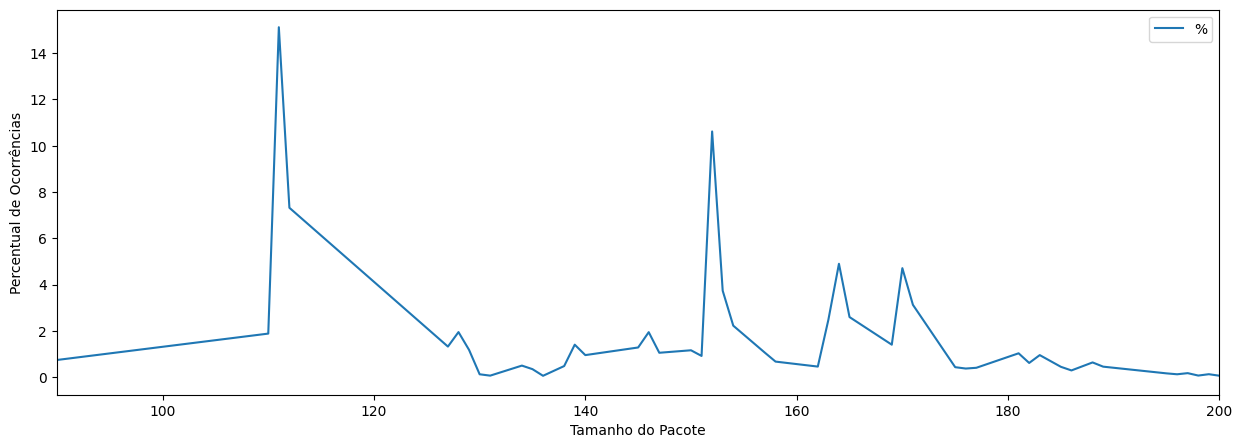

In [13]:
# create plot figure
plt.figure(figsize=(15,5))

# define the plot
ax1 = major_dataset['%'].plot()

# set legends
ax1.legend(loc=1)

# set limits for better visual
ax1.set_xlim(90, 200)

ax1.set_xlabel("Tamanho do Pacote")
ax1.set_ylabel("Percentual de Ocorrências")

# show plot
plt.show()

Let's visualize it as a pie chart, to maybe use in the future

In [14]:
pie_major_index = np.where(major_dataset['%'] >= 2.5, major_dataset.index, None)
pie_minor_index = np.where(major_dataset['%'] >= 2.5, None, major_dataset.index)

pie_major_index = pie_major_index[pie_major_index != np.array(None)]
pie_minor_index = pie_minor_index[pie_minor_index != np.array(None)]

pie_major = major_dataset.drop(pie_minor_index)
pie_major.drop(['Count'],inplace=True, axis=1)

pie_minor_sum = major_dataset.drop(pie_major_index)['%'].sum()
pie_major.loc['others'] = pie_minor_sum

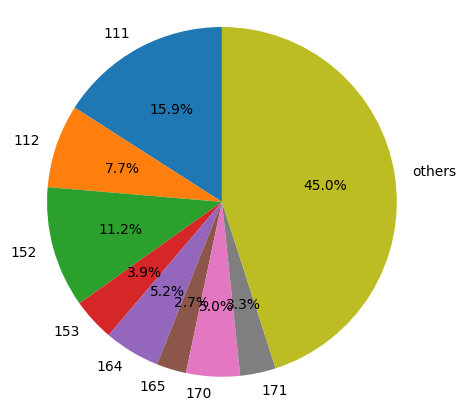

In [15]:
# define the labels
labels = pie_major.index.to_list()

# define the sizes
sizes = pie_major['%'].to_list()

# plot the pie chart
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Lets save the final dataframe to be used by the generator later on

In [16]:
size = deepcopy(major_dataset)

### 2.4 Analyzing the data based on IDT

Here the same steps will be reproduced one more time, but now in relation to the IDT property of the data

In [17]:
info

,PACKET,IDT,SIZE
0,"(1600869281.405925, b'\x08j\n\x06\x97\x06\xb4....",29,91
1,"(1600869281.439408, b'\x08j\n\x06\x97\x06\xb4....",33,86
2,"(1600869281.473451, b'\x08j\n\x06\x97\x06\xb4....",34,277
3,"(1600869281.505844, b'\x08j\n\x06\x97\x06\xb4....",32,81
4,"(1600869283.011967, b'\x08j\n\x06\x97\x06\xb4....",1506,77
...,...,...,...
30674,"(1600869604.401711, b'\x08j\n\x06\x97\x06\xb4....",203,69
30675,"(1600869604.605059, b'\x08j\n\x06\x97\x06\xb4....",203,69
30676,"(1600869604.808899, b'\x08j\n\x06\x97\x06\xb4....",203,69
30677,"(1600869605.017171, b'\x08j\n\x06\x97\x06\xb4....",208,69


Create a probability distributed function (PDF), so we can see the frequency of each packet inter-departure-time.

In [18]:
pdf = info.groupby("IDT").count()
pdf.drop(['SIZE'],inplace=True, axis=1)
pdf.columns = ['Count']
pdf["%"] = 100 * pdf["Count"] / len(info)

Lets create a copy for future comparison

In [19]:
original_idt_pdf = deepcopy(pdf)

Let's plot PDF

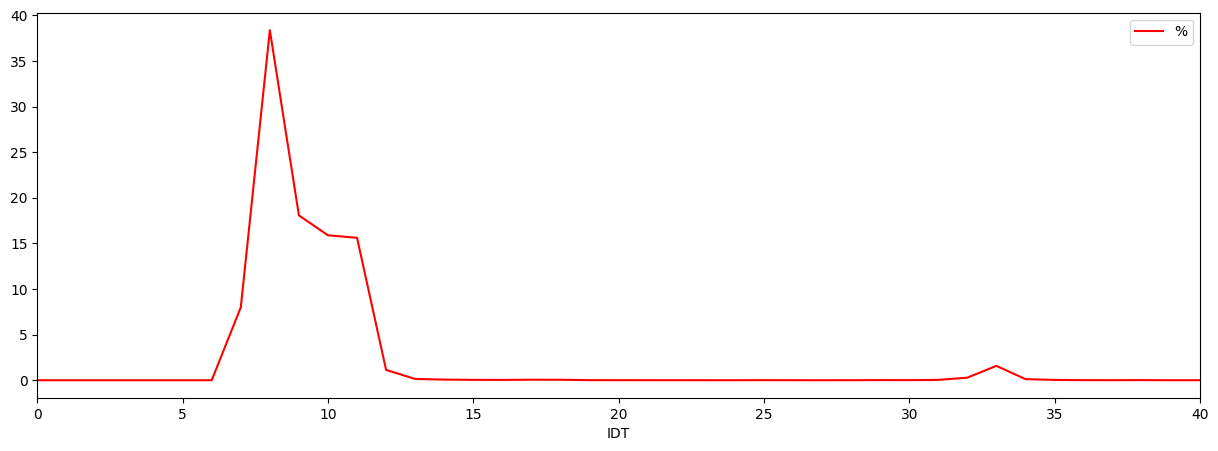

In [20]:
plt.figure(figsize=(15,5))

ax = pdf['%'].plot(label='%', color='r')
ax.legend(loc=1)
ax.set_xlim(0, 40)

plt.show()

Apply a wightened moving average to extract the most impactfull dataset points.

In [21]:
# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

In [22]:
# define the weights
weights = np.array([1,2,3,4,5,6,5,4,3,2,1])

# aply the weighted moving average
WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)

# convert series to dataframe
WMA = WMA_raw.to_frame()

Let's plot PDF in comparison with WMA

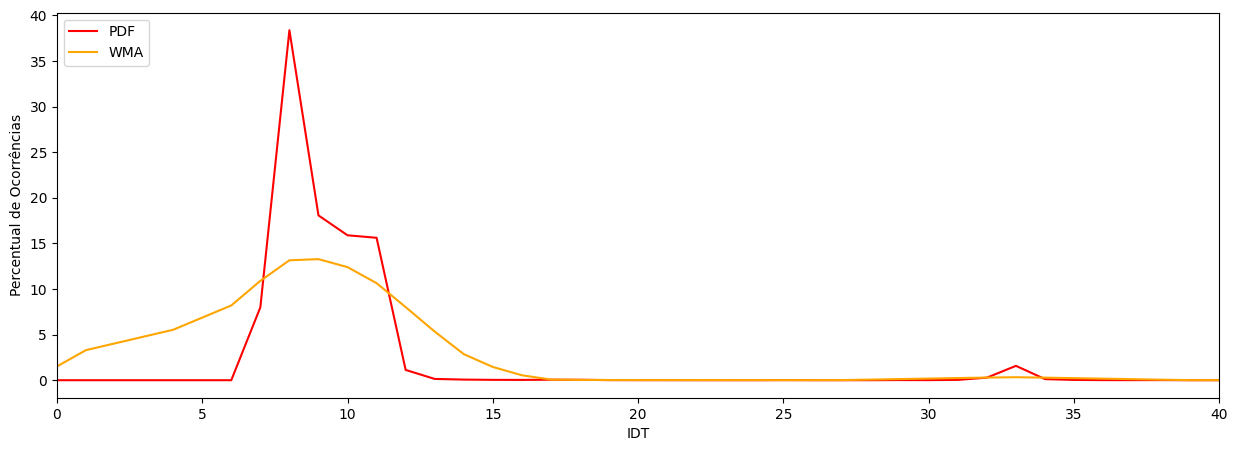

In [23]:
plt.figure(figsize=(15,5))

ax1 = pdf['%'].plot(color='red', label='PDF')
ax2 = WMA_raw.plot.line(color='orange',  label='WMA')

ax1.legend(loc=1)
ax2.legend(loc=2)

ax1.set_xlim(0, 40)
ax2.set_xlim(0, 40)

ax1.set_xlabel("IDT")
ax1.set_ylabel("Percentual de Ocorrências")

plt.show()

To populate the major dataset, we can append the PDF bigger than WMA, and do as many iteractions as we wish, depending on how simplified we want the major dataset to be.

In [24]:
# define the number of iterations of fetching relevant PDF points
N_ITER = 2

# define the major and minor datasets
major_dataset = pd.DataFrame()
minor_dataset = pd.DataFrame()

# make a usefull copy of PDF
pdf_copy = deepcopy(pdf)

# add dummy rows to pdf_copy start not to lose any data on the WMA
for i in range(pdf_copy.index.min() - 5, pdf_copy.index.min()):
    pdf_copy.loc[i] = [0, 0]

# add dummy rows to pdf_copy end not to lose any data on the WMA
for i in range(pdf_copy.index.max() + 1, pdf_copy.index.max() + 6):
    pdf_copy.loc[i] = [0, 0]

# sort the indexes again
pdf_copy.sort_index(inplace=True)

for i in range(N_ITER):
    
    # aply the weighted moving average
    WMA_raw = pdf_copy['%'].rolling(11, center=True).apply(lambda percents: np.dot(percents, weights)/weights.sum(), raw=True)
    
    # convert series to dataframe
    WMA = WMA_raw.to_frame()

    # get PDF indexes above and below WMA
    major_indexes = np.where(pdf_copy['%'] >= WMA['%'], pdf_copy['%'].index, None)
    minor_indexes = np.where(pdf_copy['%'] >= WMA['%'], None, pdf_copy['%'].index)

    # drop N/A indexes
    major_indexes = major_indexes[major_indexes != np.array(None)]
    minor_indexes = minor_indexes[minor_indexes != np.array(None)]
    
    # if first iteration
    if i == 0:
        
        # major dataset is pdf_copy without minor indexes
        major_dataset = pdf_copy.drop(minor_indexes)
        
    # not first iteration
    else:
        
        # concat current major dataset with pdf_copy without minor indexes
        frames = [major_dataset, pdf_copy.drop(minor_indexes)]
        result = pd.concat(frames)
        
        # sort major dataset
        major_dataset = result.sort_index()
        
    # minor dataset is pdf_copy without major indexes
    minor_dataset = pdf_copy.drop(major_indexes)
    
    # update pdf_copy to continue iterations using minor dataset
    pdf_copy = minor_dataset

Let's plot the major dataset to see PDF's most relevant points

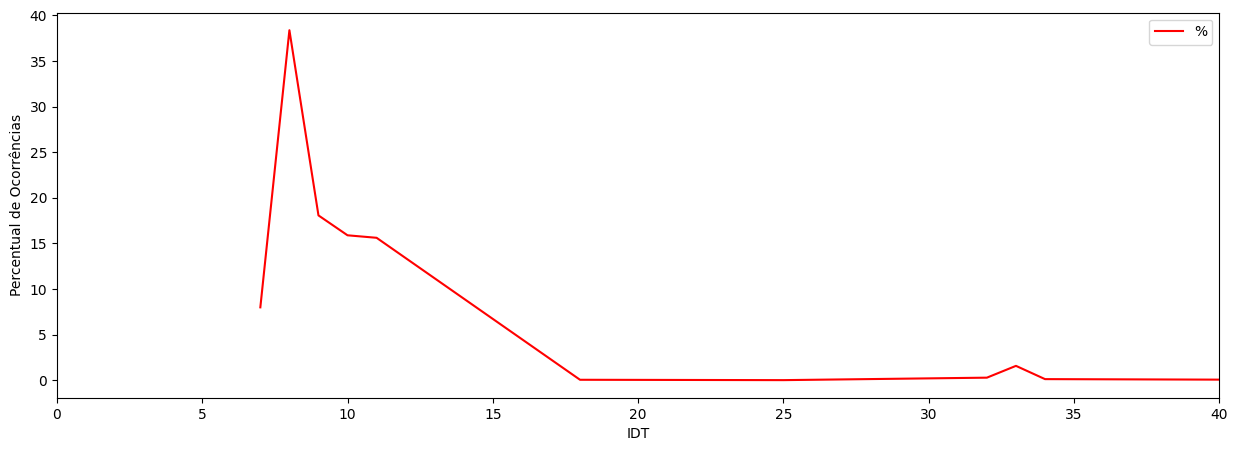

In [25]:
# create plot figure
plt.figure(figsize=(15,5))

# define the plot
ax1 = major_dataset['%'].plot(color='r')

# set legends
ax1.legend(loc=1)

# set limits for better visual
ax1.set_xlim(0, 40)

ax1.set_xlabel("IDT")
ax1.set_ylabel("Percentual de Ocorrências")

# show plot
plt.show()

Visualizing it as a pie chart

In [26]:
pie_major_index = np.where(major_dataset['%'] >= 2.5, major_dataset.index, None)
pie_minor_index = np.where(major_dataset['%'] >= 2.5, None, major_dataset.index)

pie_major_index = pie_major_index[pie_major_index != np.array(None)]
pie_minor_index = pie_minor_index[pie_minor_index != np.array(None)]

pie_major = major_dataset.drop(pie_minor_index)
pie_major.drop(['Count'],inplace=True, axis=1)

pie_minor_sum = major_dataset.drop(pie_major_index)['%'].sum()
pie_major.loc['others'] = pie_minor_sum

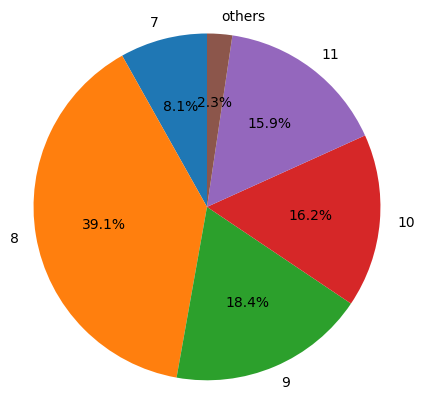

In [27]:
# define the labels
labels = pie_major.index.to_list()

# define the sizes
sizes = pie_major['%'].to_list()

# plot the pie chart
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Lets save the resulting dataframe to be used by the generator in the next steps.

In [28]:
idt = deepcopy(major_dataset)

## 3 - Generating Traffic

Based on the major datasets for IDT and SIZE, we'll be generating random (IDT, Packet) pairs, and populating a double buffered queue. This will be consumed by another thread, sending the packet between IDT time intervals.

Lets create auxiliary data for extracting relevant points based on a random function. We do this by making our pdfs be cumulative counted in relation to the amount of occurences (count), so when we get a random numer, we have the expected chance of getting each sector more or less likelly.

In [29]:
# create a Count cumulative row for size
size['CountCumulative'] = size['Count'].cumsum()

In [30]:
# create a Count cumulative row for idt
idt['CountCumulative'] = idt['Count'].cumsum()

In [31]:
def get_rand_index(df, df_max_point):
    """ Return an index based on probability of cumulative count """
    j = random.randrange(1, df_max_point)
    
    for index, row in df.iterrows():
        if j <= row['CountCumulative']:
            return index

### 3.1 Initializing generator

Here we star the double buffer

In [32]:
# define max size of each buffer
MAX_LEN = 100

# define two deques to work as producer and consumer buffers
queues = {"write": deque(maxlen=MAX_LEN), "read": deque(maxlen=MAX_LEN)}

# define an output dataframe to compare generated traffic with original
generated_traffic = pd.DataFrame(columns = ['IDT', 'SIZE', 'PACKET'])

lets create a way of easily swapping the current queue being used as load and source of data

In [33]:
def swap_queues(queues):
    """ Swap write and read queues """
    queues['write'], queues['read'] = queues['read'], queues['write']

### 3.1 Producer Thread

Creating the thread that generated SIZE IDT pairs to populate the buffers

In [34]:
def generator():
    """ I run on a thread, generating idt, packet tuples and populating a queue """
    
    print("Generator started!")
    
    # count total number of points in each dataset
    idt_points = idt["Count"].sum()
    size_points = size["Count"].sum()
    
    # keep generator running while generating_traffic
    while generating_traffic:
        
        # wait until write queue is empty
        if len(queues['write']) != 0:
            continue
        
        # populate the whole queue
        while len(queues['write']) != MAX_LEN:
        
            # generate IDT and packet
            _idt = get_rand_index(idt, idt_points)
            _size = get_rand_index(size, size_points)
            
            # enque IDT, packet tuple
            queues['write'].append((_idt, _size))
            
    print("Generator shutting down!")

### 3.2 Consumer Thread

Creating the thread that will consume data from the buffer

In [35]:
def transmitter():
    """ I run on a thread, consuming a queue to transmit a packet in idt intervals """
    
    print("Transmitter started!")
    
    # keep transmitter running while generating_traffic
    while generating_traffic:
        
        # read queue is not empty
        if len(queues["read"]) != 0:
            
            # get idt, packet tuple from queue
            packet = queues["read"].pop()
            
            # tranmit packet in idt time
            transmit_in_time(packet)
        
        # read queue empty: swap queues
        else:
            swap_queues(queues)
            
    print("Transmitter shutting down!")

Making a function to help us acctually transmit the packets consumed in the determined IDT

In [36]:
def transmit_in_time(packet):
    """ Wait for idt time in miliseconds to transmit a packet """
    # use global output dataframe
    global generated_traffic
    
    # set target time
    t = datetime.datetime.now() + datetime.timedelta(milliseconds=packet[0])
    
    # wait for target time
    while t > datetime.datetime.now():
        continue
    
    # transmit package
    #generated_traffic = generated_traffic.append({'IDT': packet[0], 'SIZE': packet[1], 'PACKET': None}, ignore_index = True)
    frames = [generated_traffic, pd.DataFrame.from_records([{'IDT': packet[0], 'SIZE': packet[1], 'PACKET': None}])]
    generated_traffic = pd.concat(frames)
    
    return

### 3.3 Running the packet generator

In [37]:
# create threads for producer and consumer
p = threading.Thread(name='producer', target=generator)
c = threading.Thread(name='consumer', target=transmitter)

# start the generator
generating_traffic = True

# start the producer
p.start()

# wait a second for producer to fill first queue
time.sleep(1)

# start consumer
c.start()

# run the packet generator for 10 seconds and then shut down
time.sleep(30)
generating_traffic = False

Generator started!
Transmitter started!
Generator shutting down!


## 4 - Analyzing generated traffic

In [38]:
generated_traffic

,IDT,SIZE,PACKET
0,9,111,None
0,10,288,None
0,9,164,None
0,10,171,None
0,8,153,None
...,...,...,...
0,9,165,None
0,8,112,None
0,9,152,None
0,9,110,None


Let's once again create a PDF, now of the resulting data

In [39]:
pdf = generated_traffic.groupby("SIZE").count()
pdf.drop(['PACKET'],inplace=True, axis=1)
pdf.columns = ['Count']
pdf["%"] = 100 * pdf["Count"] / len(generated_traffic)

Transmitter shutting down!


Let's plot the generated PDF in comparison to the original data

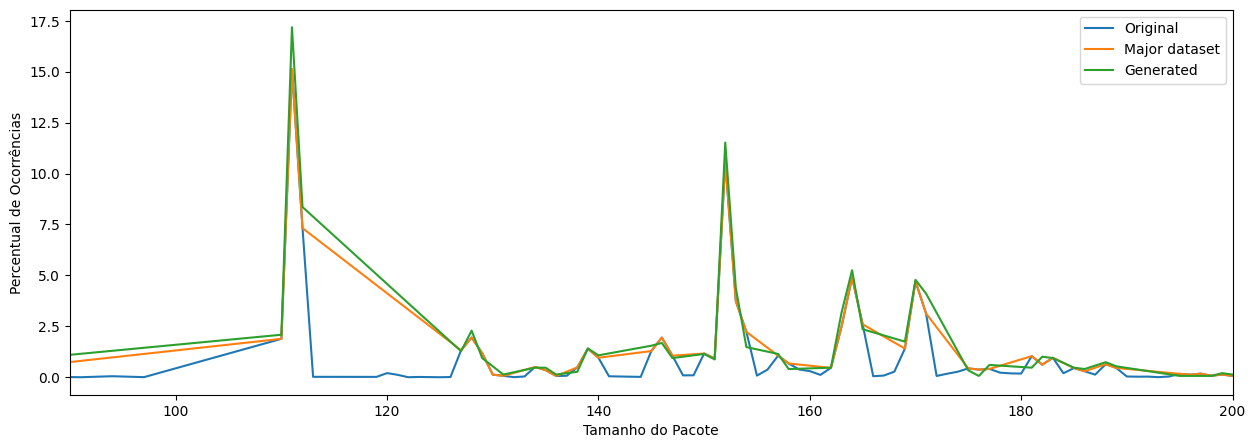

In [40]:
# define figure dimension
plt.figure(figsize=(15,5))

# plot original pdf
ax1 = original_size_pdf['%'].plot(label='Original')
ax1.legend(loc=1)
ax1.set_xlim(90, 200)

ax2 = size['%'].plot(label='Major dataset')
ax2.legend(loc=1)
ax2.set_xlim(90, 200)

ax3 = pdf['%'].plot(label='Generated')
ax3.legend(loc=1)
ax3.set_xlim(90, 200)

ax1.set_xlabel("Tamanho do Pacote")
ax1.set_ylabel("Percentual de Ocorrências")


# display plot result
plt.show()

Now let's see the comparison based on IDT

In [41]:
pdf = generated_traffic.groupby("IDT").count()
pdf.drop(['PACKET'],inplace=True, axis=1)
pdf.columns = ['Count']
pdf["%"] = 100 * pdf["Count"] / len(generated_traffic)

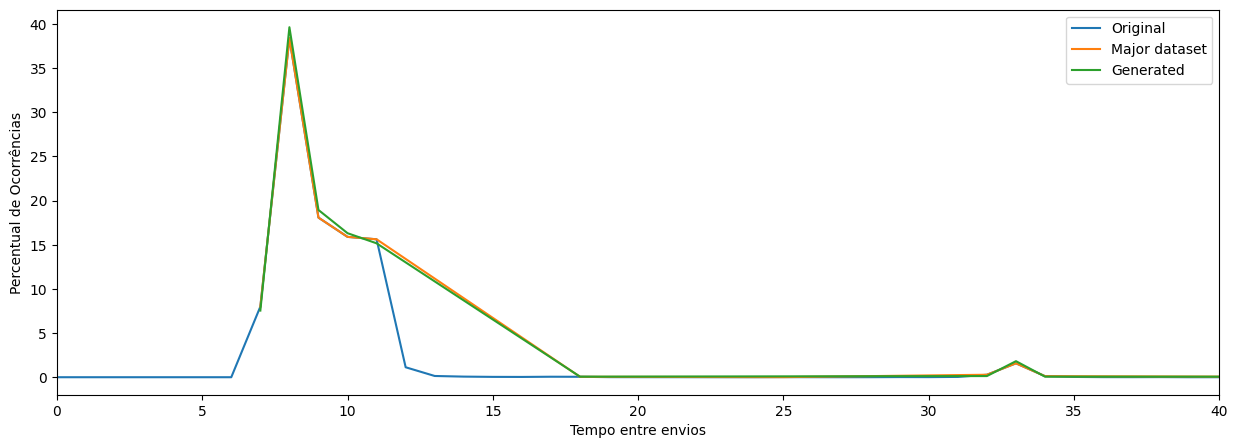

In [42]:
# define figure dimension
plt.figure(figsize=(15,5))

# plot original pdf
ax1 = original_idt_pdf['%'].plot(label='Original')
ax1.legend(loc=1)
ax1.set_xlim(0, 40)

ax2 = idt['%'].plot(label='Major dataset')
ax2.legend(loc=1)
ax2.set_xlim(0, 40)

ax3 = pdf['%'].plot(label='Generated')
ax3.legend(loc=1)
ax3.set_xlim(0, 40)

ax1.set_xlabel("Tempo entre envios")
ax1.set_ylabel("Percentual de Ocorrências")


# display plot result
plt.show()

## 5 - Using the traffic generator to evaluate a game server

Up to this point, we can no longer use real game packets, so we transition to custom made game to acctually communicate with a real server and test it's performance.

For this, we will repeate all the procedure done here, using the custom game captured packets.

Following in the CUSTOM_GAME.ipynb